## Importing Libraries

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## Importing the Data

In [12]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data() #Ignoring Labels as we are performing Reconstruction
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255. #Normalizing the data
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

## Encoder

In [13]:
class Encoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.d = layers.Dense(latent_dim + latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d(x)
        return x

## Decoder

In [14]:
class Decoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(7*7*64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.convT1 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.convT1(z)
        z = self.convT2(z)
        z = self.convT3(z)
        return z

## Reparametrization

In [15]:
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x):
        encoded = self.encoder(x)
        z_mean, z_log_var = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        kl_coefficient = 0.001  # Example coefficient, adjust based on experimentation.
        self.add_loss(kl_coefficient * kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return eps * tf.exp(z_log_var * .5) + z_mean

## Plotting Images

In [16]:
def plot_images(original, reconstructed, latent_dim):
    n = 6 # Number of digits to display
    plt.figure(figsize=(20, 6))
    title = f'Latent Dimensions: {latent_dim}'
    plt.suptitle(title, fontsize=20)
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.title("Test Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.title("Test Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## VAE with 2 Latent Dimensions

In [17]:
latent_dim = 2
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10


938/938 [==============================] - 59s 62ms/step - loss: 0.0611 - val_loss: 0.0513
Epoch 2/10
938/938 [==============================] - 57s 60ms/step - loss: 0.0497 - val_loss: 0.0487
Epoch 3/10
938/938 [==============================] - 61s 65ms/step - loss: 0.0480 - val_loss: 0.0477
Epoch 4/10
938/938 [==============================] - 60s 63ms/step - loss: 0.0471 - val_loss: 0.0468
Epoch 5/10
938/938 [==============================] - 59s 63ms/step - loss: 0.0465 - val_loss: 0.0468
Epoch 6/10
938/938 [==============================] - 58s 62ms/step - loss: 0.0461 - val_loss: 0.0459
Epoch 7/10
938/938 [==============================] - 59s 63ms/step - loss: 0.0457 - val_loss: 0.0460
Epoch 8/10
938/938 [==============================] - 58s 62ms/step - loss: 0.0454 - val_loss: 0.0456
Epoch 9/10
938/938 [==============================] - 58s 62ms/step - loss: 0.0452 - val_loss: 0.0454
Epoch 10/10
938/938 [==============================] - 58s 62ms/step - loss: 0.0450 - val_los

In [18]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 3s 10ms/step
Test MSE: 0.04236593


157/157 [==============================] - 3s 18ms/step


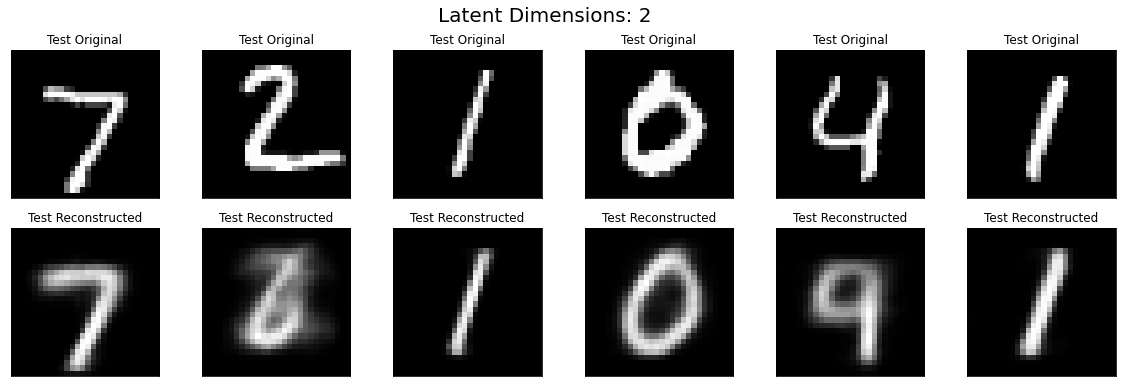

In [19]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 4 Latent Dimensions

In [20]:
latent_dim = 4
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 53s 56ms/step - loss: 0.0505 - val_loss: 0.0369
Epoch 2/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0359 - val_loss: 0.0348
Epoch 3/10
938/938 [==============================] - 52s 55ms/step - loss: 0.0344 - val_loss: 0.0342
Epoch 4/10
938/938 [==============================] - 53s 56ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 5/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0331 - val_loss: 0.0330
Epoch 6/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0327 - val_loss: 0.0326
Epoch 7/10
938/938 [==============================] - 53s 56ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 8/10
938/938 [==============================] - 52s 55ms/step - loss: 0.0321 - val_loss: 0.0322
Epoch 9/10
938/938 [==============================] - 52s 56ms/step - loss: 0.0319 - val_loss: 0.0320
Epoch 10/10
938/938 [==============================] - 52s 56ms/step - loss: 0.031

In [21]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 3s 10ms/step
Test MSE: 0.029064655


157/157 [==============================] - 3s 18ms/step


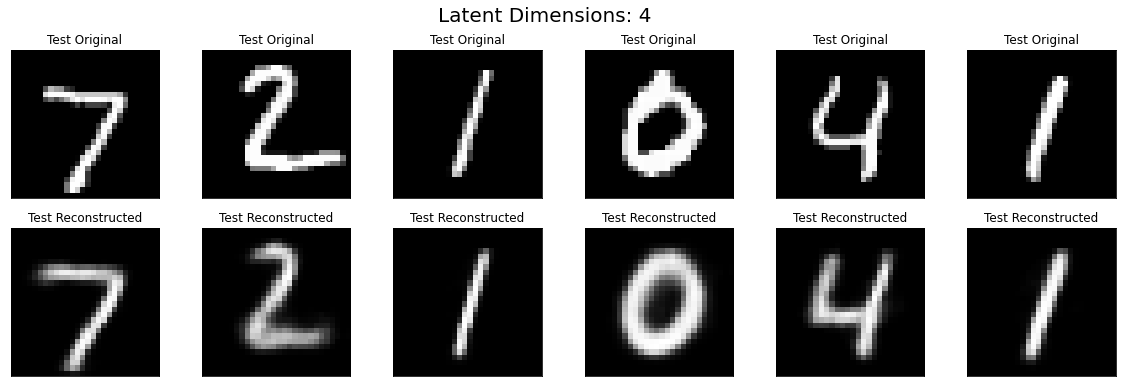

In [22]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 8 Latent Dimensions

In [23]:
latent_dim = 8
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 53s 56ms/step - loss: 0.0397 - val_loss: 0.0245
Epoch 2/10
938/938 [==============================] - 62s 67ms/step - loss: 0.0232 - val_loss: 0.0219
Epoch 3/10
938/938 [==============================] - 68s 73ms/step - loss: 0.0216 - val_loss: 0.0208
Epoch 4/10
938/938 [==============================] - 67s 72ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 5/10
938/938 [==============================] - 65s 69ms/step - loss: 0.0200 - val_loss: 0.0198
Epoch 6/10
938/938 [==============================] - 65s 69ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 7/10
938/938 [==============================] - 65s 69ms/step - loss: 0.0193 - val_loss: 0.0192
Epoch 8/10
938/938 [==============================] - 65s 70ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 9/10
938/938 [==============================] - 66s 70ms/step - loss: 0.0188 - val_loss: 0.0188
Epoch 10/10
938/938 [==============================] - 66s 70ms/step - loss: 0.018

In [24]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 4s 12ms/step
Test MSE: 0.015986444


157/157 [==============================] - 4s 22ms/step


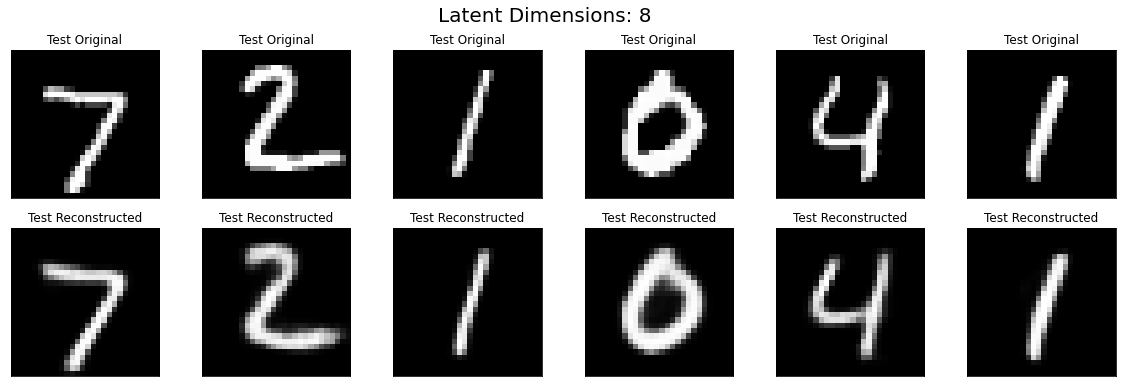

In [25]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 16 Latent Dimensions

In [26]:
latent_dim = 16
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 1028s 1s/step - loss: 0.0319 - val_loss: 0.0148
Epoch 2/10
938/938 [==============================] - 61s 65ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 3/10
938/938 [==============================] - 66s 71ms/step - loss: 0.0124 - val_loss: 0.0119
Epoch 4/10
938/938 [==============================] - 28s 30ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 5/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 7/10
938/938 [==============================] - 38s 41ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 8/10
938/938 [==============================] - 38s 40ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/10
938/938 [==============================] - 38s 40ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 10/10
938/938 [==============================] - 39s 42ms/step - loss: 0.010

In [27]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 3s 7ms/step
Test MSE: 0.007661231


157/157 [==============================] - 2s 14ms/step


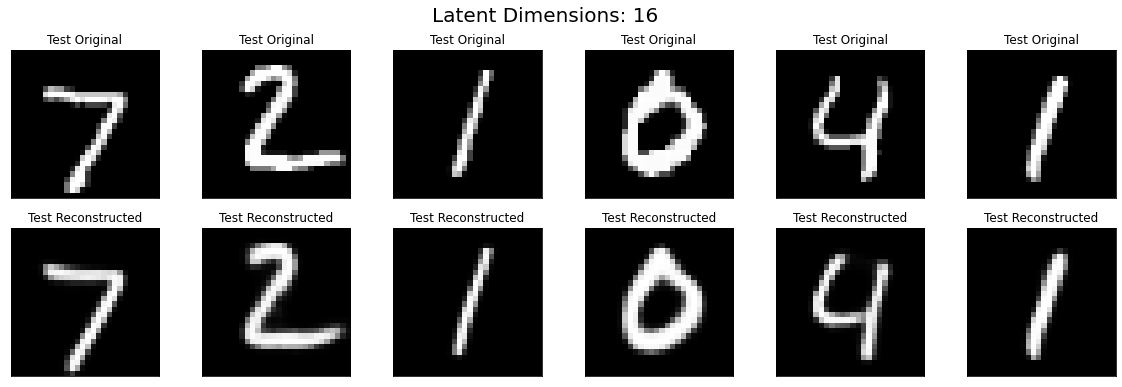

In [28]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 32 Latent Dimensions

In [29]:
latent_dim = 32
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 39s 41ms/step - loss: 0.0263 - val_loss: 0.0092
Epoch 2/10
938/938 [==============================] - 40s 43ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 3/10
938/938 [==============================] - 40s 43ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/10
938/938 [==============================] - 40s 43ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 5/10
938/938 [==============================] - 47s 50ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 6/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/10
938/938 [==============================] - 49s 52ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/10
938/938 [==============================] - 47s 50ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/10
938/938 [==============================] - 53s 57ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 10/10
938/938 [==============================] - 60s 64ms/step - loss: 0.006

In [30]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 4s 11ms/step
Test MSE: 0.0039663506


157/157 [==============================] - 3s 19ms/step


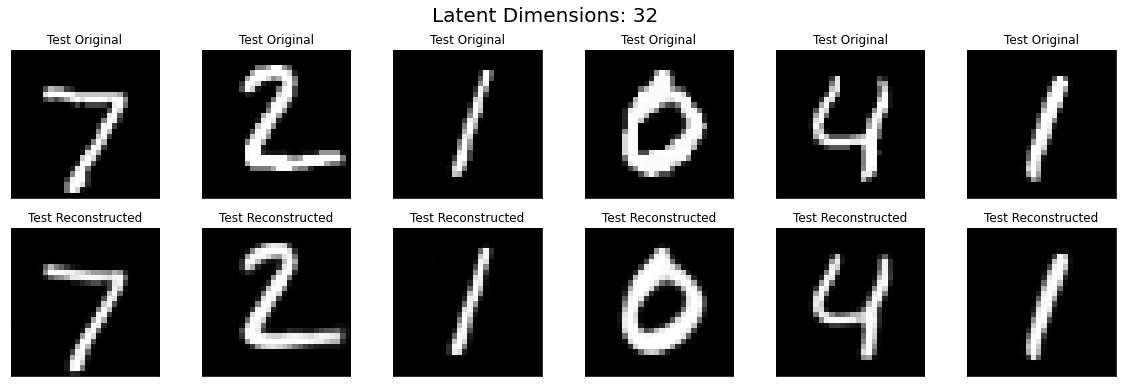

In [31]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## VAE with 64 Latent Dimensions

In [32]:
latent_dim = 64
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

Epoch 1/10
938/938 [==============================] - 66s 70ms/step - loss: 0.0235 - val_loss: 0.0074
Epoch 2/10
938/938 [==============================] - 63s 68ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 3/10
938/938 [==============================] - 66s 70ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 4/10
938/938 [==============================] - 65s 70ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 5/10
938/938 [==============================] - 71s 75ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/10
938/938 [==============================] - 69s 73ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/10
938/938 [==============================] - 68s 73ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/10
938/938 [==============================] - 70s 74ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/10
938/938 [==============================] - 70s 74ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/10
938/938 [==============================] - 68s 72ms/step - loss: 0.004

In [33]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)

313/313 [==============================] - 4s 12ms/step
Test MSE: 0.0023885749


157/157 [==============================] - 3s 22ms/step


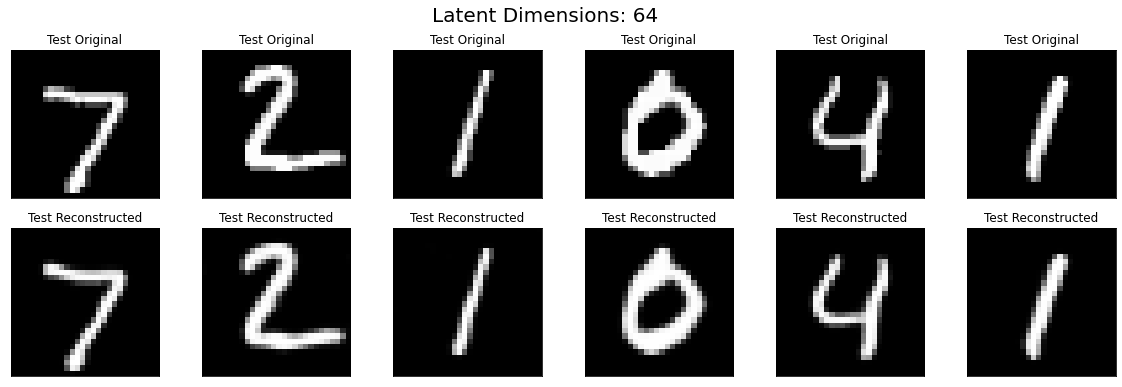

In [34]:
# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)

## MSE Error 

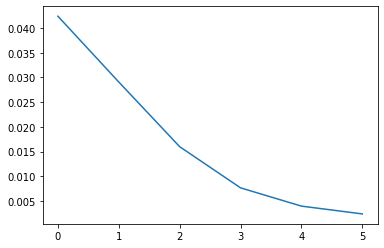

In [39]:
mse_list = [0.04236593, 0.029064655, 0.015986444, 0.007661231, 0.0039663506, 0.0023885749]
plt.plot(mse_list)